In [86]:
import numpy as np
import matplotlib.pyplot as plt

from numpy.random import default_rng
import math

test_proportion = 0.1
num_samples_max = 1000
batch_size = 16

Requriments:

- **Ratios** of different size inputs are passed via a tuple: e.g., (.9, .1, .07, .03), which means that we want 90% of data to be the lowest res, 10% to be second lowest res, and so on.  For any given dataset (Darcy, Burgers, Navier Stokes, Incompressible Navier Stokes), we support a fixed number of resolutions (documented in the class doc string)

- We also **pre-batch** all of our data so that, we can ensure that datasamples from the same res are in each batch. Otherwise, we would need to enforce batch_size=1 which is prohibitively slow in some cases w/ long time step datasets. Or we would need to use padding, which may not make physical sense considering boundry contidtions.

- We also need to return **multiple resolutions of test data** (this is done outside of the intial data class)

In [54]:
rng = default_rng(seed=0)

data_idx = np.arange(0,num_samples_max)
test_idx = int(num_samples_max*test_proportion)
test_idxs = data_idx[:test_idx]
train_idxs = data_idx[test_idx:num_samples_max]

resolution_proportions = [0.8, 0.1, 0.07, 0.03]
#resolution_idxs = []
num_train_samples = len(train_idxs)
rng.shuffle(train_idxs)

res_sets = []
for ratio in resolution_proportions:
    res_idx = int(num_train_samples * ratio)
    #resolution_idxs.append(res_idx)
    res_sets.append(train_idxs[:res_idx])
    train_idxs = train_idxs[res_idx:]
# can just pass in # of samples or maybe 
len(res_sets[0])

720

In [52]:
total_count = 0
for i in range(4):
    total_count += len(res_sets[i])

total_count

900

In [67]:
num_of_train_batches = math.ceil(num_train_samples / batch_size)
num_of_train_batches

batch_idx = 45

for res_set in res_sets:
    num_batches_in_set = math.ceil(len(res_set) / batch_size)
    print(f"{num_batches_in_set=}")
    if batch_idx >= num_batches_in_set:
        batch_idx -= num_batches_in_set
    else:
        print(f"in correct set, {len(res_set)=}")
        item_idx = int(batch_idx*batch_size)
        sample = res_set[item_idx:item_idx+batch_size]
        break

sample

num_batches_in_set=6
num_batches_in_set=1
num_batches_in_set=1
num_batches_in_set=1


836

In [65]:
np.concatenate(res_sets).shape

(900,)

In [5]:
from __future__ import annotations

import typing
from pathlib import Path

import h5py
import numpy as np
from torch.utils.data import Dataset
from torchvision.transforms import Compose
import torch

# https://github.com/pdebench/PDEBench/blob/main/pdebench/models/fno/utils.py

self.num_samples=9000


TypeError: Invalid shape (128,) for image data

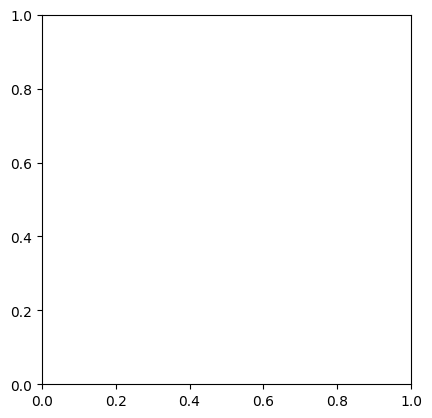

In [104]:
class BurgersPDEBench(Dataset):
    """Burger Dataset from PDE Bench."""

    def __init__(
        self,
        filename: str,
        initial_step: int = 10,
        saved_folder: str = '../data/',
        train: bool = False,
        transform: Compose = None,
        **kwargs: typing.Any,
    ):
        """Initialize data.
        
        support img dimentions: 1024, 512, 256, 128 (highest to lowest)
        """
        self.transform = transform
        # Time steps used as initial conditions
        self.initial_step = initial_step
        
        resolution_proportions = kwargs['resolution_proportions']
        four = 4
        assert len(resolution_proportions) == four, (
            'Only support 4 img_resolutions, see doc string.'
        )
        assert sum(resolution_proportions) == 1, (
            'All dataset proportions must sum to 1.'
        )
        self.rng = default_rng(seed=kwargs['seed'])
        self.batch_size = kwargs['batch_size']
        test_ratio = 0.1
        num_samples_max = -1
        reduced_resolution_t = 2

        self.data_sets = []
        root_path = Path(Path(saved_folder).resolve()) / filename
        with h5py.File(root_path, 'r') as f:
            # num of data samples
            num_samples_max = f['tensor'].shape[0]

            # list of data idxs
            data_idx = np.arange(0, num_samples_max)
            # num of test samples
            test_idx = int(num_samples_max * test_ratio)
            if train:
                first_batch_idx = test_idx
                last_batch_idx = -1
                self.num_samples = num_samples_max - test_idx
            else:
                first_batch_idx = 0
                last_batch_idx = test_idx
                self.num_samples = test_idx
            print(f'{self.num_samples=}')
            # grab data indexs
            self.data_idxs = data_idx[first_batch_idx:last_batch_idx]
            # shuffle indexes
            self.rng.shuffle(self.data_idxs)
                    
        # Define path to files
        root_path = Path(Path(saved_folder).resolve()) / filename
        for res_factor, ratio in enumerate(resolution_proportions):
            reduced_resolution = 2**res_factor
            with h5py.File(root_path, 'r') as f:
                # number of points in this resolution set
                res_idx = int(self.num_samples * ratio)
                # sort all indexes
                set_indexes = np.sort(self.data_idxs[:res_idx])
                
                ## data dim = [t, x1, ..., xd, v]
                _data = np.array(
                    f['tensor'], dtype=np.float32
                )  # batch, time, x,...
                _data = _data[
                    set_indexes,
                    ::reduced_resolution_t,
                    ::reduced_resolution,
                ]
                # batch, time, channel, x,
                self.data = torch.tensor(_data[:, :, None, :])

    def __len__(self) -> int:
        """Returns len of dataset.

        Recall this is a pre-batched dataset, so we return
        number of batches.
        """
        return math.ceil(self.num_samples / self.batch_size)

    def __getitem__(self, idx: int) -> dict[str, torch.Tensor]:
        """Get single sample at idx."""
        sample = {
            'x': self.data[idx, : self.initial_step, ...],
            'y': self.data[idx, ...],
            # self.grid,
        }

        if self.transform:
            sample = self.transform(sample)

        return sample

batch_size = 137
dataset_name = 'burger_pdebench'
initial_steps = 10
filter_lim = -1
downsample_dim = -1
model_name = 'FNO1D'
darcy_forcing_term = 1.0
burger_viscosity = 1.0
train = True
data_transforms = None
img_size = 1024

dataset = BurgersPDEBench(
            filename=f'1D_Burgers_Sols_Nu{burger_viscosity}.hdf5',
            initial_step=10,
            saved_folder='/pscratch/sd/m/mansisak/PDEBench/pdebench_data/1D/Burgers/Train/',
            # reduced_resolution=1,
            train=train,
            transform=data_transforms,
            img_size=img_size,
            batch_size=batch_size,
            resolution_proportions = [0.03, 0.07,0.1,0.8],
            seed=0,
        )

plt.imshow(dataset[0]['x'][0,0,...])
plt.show()

In [97]:
total_sample = 0

for i in range(len(dataset)+1):
    sample_count = len(dataset[i]['x'])
    if sample_count != batch_size:
        print(sample_count)
    total_sample += sample_count

total_sample

133
82
78
75


8999

In [80]:
len(dataset)

90

In [87]:
dataset[90]

{'x': tensor([[[[1.0000, 1.0000, 1.0000,  ..., 0.1000, 0.1000, 0.1000],
           [1.0000, 1.0000, 1.0000,  ..., 0.1000, 0.1000, 0.1000],
           [1.0000, 1.0000, 1.0000,  ..., 0.1000, 0.1000, 0.1000],
           ...,
           [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
           [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
           [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000]]],
 
 
         [[[0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
           [0.1000, 0.1000, 1.0000,  ..., 0.1000, 0.1000, 0.1000],
           [0.1000, 0.1000, 1.0000,  ..., 1.0000, 0.1000, 0.1000],
           ...,
           [0.1000, 0.1000, 0.1000,  ..., 1.0000, 1.0000, 0.1000],
           [0.1000, 0.1000, 0.1000,  ..., 1.0000, 0.1000, 0.1000],
           [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000]]],
 
 
         [[[0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
           [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
           [0